# Data on US Honey Production in years 1995-2021 - correctness analysis

### In this notebook, I am showing my analysis of the correctness of the kaggle dataset US_honey_dataset_updated.csv (access: 30.01.2023). I am also explaining what and why I think is erroneous and how I attempted to fix it.

The dataset is available at:

https://www.kaggle.com/code/drshashikanthvydyula/us-honey-production-1995-2021/data

In [1]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
filepath = "../input/us-honey-production-19952021/US_honey_dataset_updated.csv"
df = pd.read_csv(filepath, index_col="Unnamed: 0")

### First peek at the data

In [3]:
df.head()

,state,colonies_number,yield_per_colony,production,stocks,average_price,value_of_production,year
0,Alabama,16000,58,928000,28000,62.0,575000,1995
1,Arizona,52000,79,4108000,986000,68.0,2793000,1995
2,Arkansas,50000,60,3000000,900000,64.0,1920000,1995
3,California,420000,93,39060000,4687000,60.0,23436000,1995
4,Colorado,45000,60,2700000,1404000,68.0,1836000,1995


In [4]:
df.tail()

,state,colonies_number,yield_per_colony,production,stocks,average_price,value_of_production,year
1110,Virginia,6000,40,79000,79000,8.23,1975000,2021
1111,Washington,96000,32,1206000,1206000,2.52,7741000,2021
1112,WestVirginia,6000,43,136000,136000,4.80,1238000,2021
1113,Wisconsin,42000,47,750000,750000,2.81,5547000,2021
1114,Wyoming,38000,58,242000,242000,2.07,4562000,2021


In [5]:
# Create a dict: column -> data type, with numeric columns only
df_dtypes_num = df.select_dtypes(include='number').dtypes.to_dict()
print(df_dtypes_num)
print(type(df_dtypes_num))

{'colonies_number': dtype('int64'), 'yield_per_colony': dtype('int64'), 'production': dtype('int64'), 'stocks': dtype('int64'), 'average_price': dtype('float64'), 'value_of_production': dtype('int64'), 'year': dtype('int64')}
<class 'dict'>


In [6]:
df.describe().astype(df_dtypes_num)

,colonies_number,yield_per_colony,production,stocks,average_price,value_of_production,year
count,1115,1115,1115,1115,1115.000000,1115,1115
mean,62438,59,2851268,1172625,140.623076,5667411,2007
std,92648,19,5561202,2049555,107.011544,9459460,7
min,2000,19,12000,9000,1.300000,106000,1995
25%,9000,45,246000,112500,70.000000,1008000,2001
50%,26000,57,828000,370000,128.000000,2281000,2008
75%,69000,71,2700000,1253500,193.000000,5704000,2015
max,550000,155,39060000,13545000,874.000000,83859000,2021


We will now analyze all the columns one by one. 

There is nothing extraordinary about the number of colonies - to me, it seems alright. 

The range of values of yield per colony also looks likely - according to USDA, an average yield per colony in the years 2010-2020 was 59 pounds per colony:

https://www.ers.usda.gov/data-products/chart-gallery/gallery/chart-detail/?chartId=102065

The average price, however, varies a lot. 

What does it look like on a chart?

<AxesSubplot:xlabel='year', ylabel='average_price'>

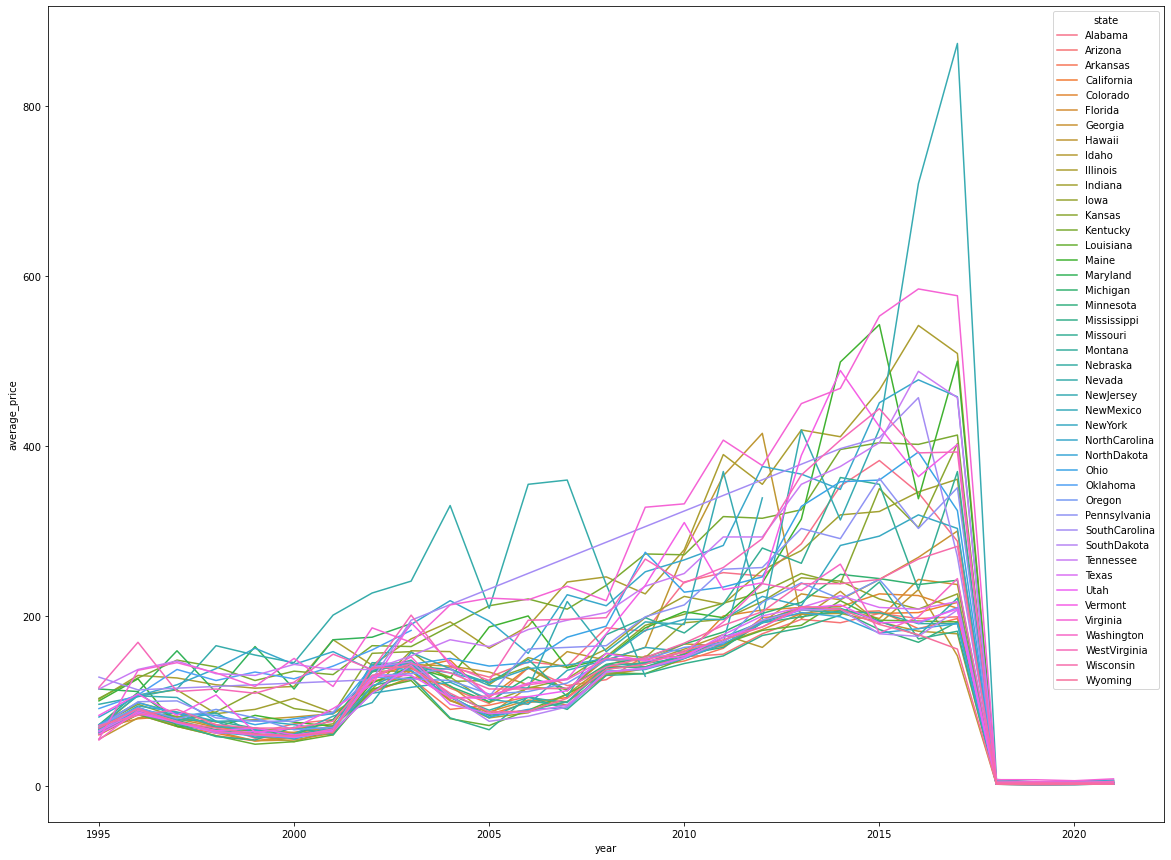

In [7]:
plt.figure(figsize=(20, 15))
sns.lineplot(x=df["year"], y=df["average_price"], hue=df["state"])

Clearly, something is wrong with the data starting from 2018. 

My guess is a difference in units - usually, the price of honey is reported in cents per pound, while here, since 2018 it looks like dollars per pound. Let us check this possibility.

In [8]:
df['average_price_v2'] = df['average_price']
df.loc[df['year'] > 2017, 'average_price_v2'] = df['average_price'].apply(lambda x: x*100)
df.describe().astype(df_dtypes_num)

,colonies_number,yield_per_colony,production,stocks,average_price,value_of_production,year,average_price_v2
count,1115,1115,1115,1115,1115.000000,1115,1115,1115.000000
mean,62438,59,2851268,1172625,140.623076,5667411,2007,184.638565
std,92648,19,5561202,2049555,107.011544,9459460,7,116.644249
min,2000,19,12000,9000,1.300000,106000,1995,49.000000
25%,9000,45,246000,112500,70.000000,1008000,2001,102.500000
50%,26000,57,828000,370000,128.000000,2281000,2008,155.000000
75%,69000,71,2700000,1253500,193.000000,5704000,2015,223.000000
max,550000,155,39060000,13545000,874.000000,83859000,2021,874.000000


<AxesSubplot:xlabel='year', ylabel='average_price_v2'>

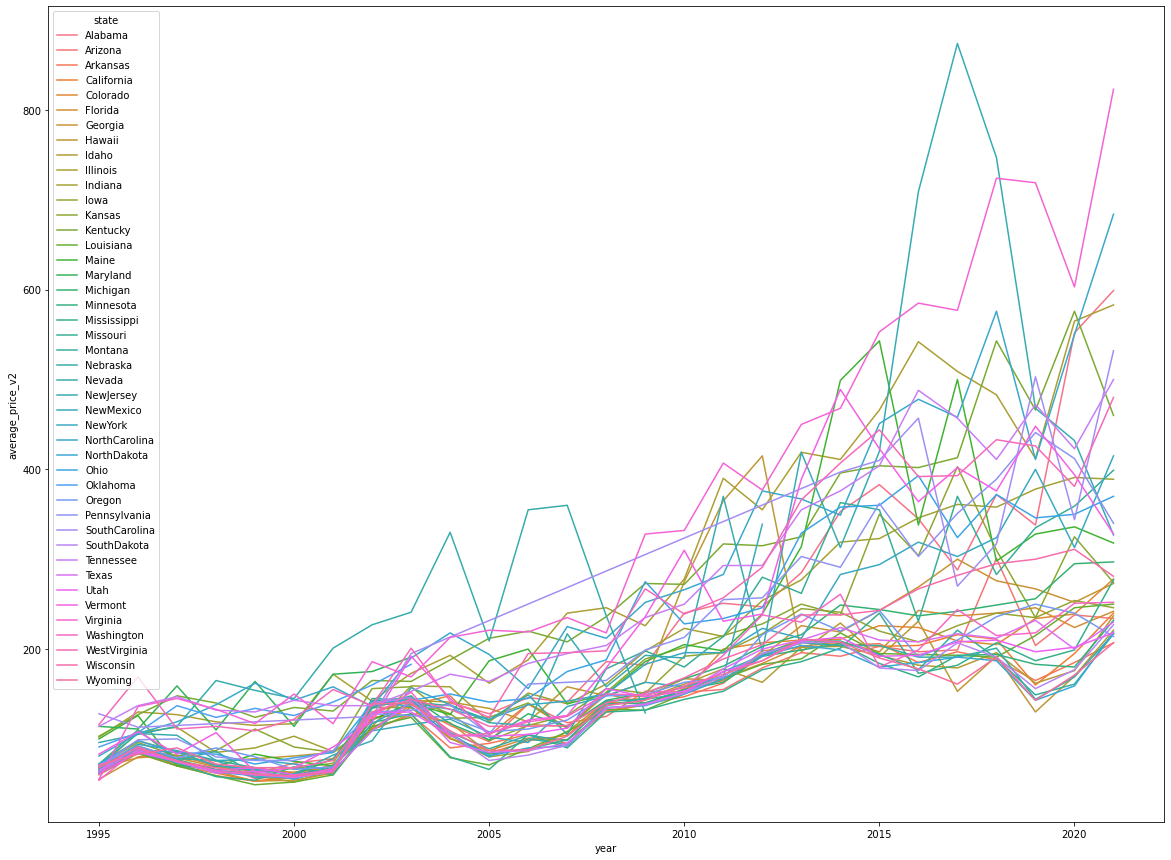

In [9]:
plt.figure(figsize=(20, 15))
sns.lineplot(x=df["year"], y=df["average_price_v2"], hue=df["state"])

Now it seems correct.

How about other columns? 

If we go back to df.head() and df.tail(), we can see that for the years 1995-2017, production equals colonies_number times yield_per_colony, and value_of_production equals production times average_price (but in dollars and rounded to full thousands).

However, that is not true for the data for the years 2018-2021, which may mean an error in this part of the dataset. What is suspicious, is the equal values for production and stocks. Let us update production for these years based on colonies_number and yield_per_colony.

In [10]:
df['production_v2'] = df['production']
df.loc[df['year'] > 2017, 'production_v2'] = df['colonies_number'] * df['yield_per_colony']

In [11]:
df['value_of_production_v2'] = df['value_of_production']
df.loc[df['year'] > 2017, 'value_of_production_v2'] = (df['production_v2'] * df['average_price_v2'] / 100).round(-3)
df['value_of_production_v2'] = df['value_of_production_v2'].astype(int)

In [12]:
df.head()

,state,colonies_number,yield_per_colony,production,stocks,average_price,value_of_production,year,average_price_v2,production_v2,value_of_production_v2
0,Alabama,16000,58,928000,28000,62.0,575000,1995,62.0,928000,575000
1,Arizona,52000,79,4108000,986000,68.0,2793000,1995,68.0,4108000,2793000
2,Arkansas,50000,60,3000000,900000,64.0,1920000,1995,64.0,3000000,1920000
3,California,420000,93,39060000,4687000,60.0,23436000,1995,60.0,39060000,23436000
4,Colorado,45000,60,2700000,1404000,68.0,1836000,1995,68.0,2700000,1836000


In [13]:
df.tail()

,state,colonies_number,yield_per_colony,production,stocks,average_price,value_of_production,year,average_price_v2,production_v2,value_of_production_v2
1110,Virginia,6000,40,79000,79000,8.23,1975000,2021,823.0,240000,1975000
1111,Washington,96000,32,1206000,1206000,2.52,7741000,2021,252.0,3072000,7741000
1112,WestVirginia,6000,43,136000,136000,4.80,1238000,2021,480.0,258000,1238000
1113,Wisconsin,42000,47,750000,750000,2.81,5547000,2021,281.0,1974000,5547000
1114,Wyoming,38000,58,242000,242000,2.07,4562000,2021,207.0,2204000,4562000


Voila! It looks like our investigation was quite successful. 

As a precaution, let us also check for duplicates.

In [14]:
df.duplicated().sum()

0

There are no duplicated rows in our dataset.

Now it would be useful to turn all our changes into a function.

In [15]:
def fix_us_honey_dataset(df_wrong):
    """
    Fix the kaggle dataset on US Honey Production 1995-2021.
    """
    
    df_wrong['average_price_v2'] = df_wrong['average_price']
    
    df_wrong.loc[df['year'] > 2017, 'average_price_v2'] = df_wrong['average_price'].apply(lambda x: x*100)
    
    df_wrong['production_v2'] = df['production']
    df_wrong.loc[df_wrong['year'] > 2017, 'production_v2'] = df_wrong['colonies_number'] * df_wrong['yield_per_colony']
    
    df_wrong['value_of_production_v2'] = df_wrong['value_of_production']
    df_wrong.loc[df_wrong['year'] > 2017, 'value_of_production_v2'] = (df_wrong['production_v2'] * df_wrong['average_price_v2'] / 100).round(-3)
    df_wrong['value_of_production_v2'] = df_wrong['value_of_production_v2'].astype(int)
    
    df_correct = df_wrong[['state', 'colonies_number', 'yield_per_colony', 'production_v2', 'stocks', 'average_price_v2', 'value_of_production_v2', 'year']]
    df_correct.columns = ['state', 'colonies_number', 'yield_per_colony', 'production', 'stocks', 'average_price', 'value_of_production', 'year']
    
    return df_correct

In [16]:
df = fix_us_honey_dataset(df)
df.head()

,state,colonies_number,yield_per_colony,production,stocks,average_price,value_of_production,year
0,Alabama,16000,58,928000,28000,62.0,575000,1995
1,Arizona,52000,79,4108000,986000,68.0,2793000,1995
2,Arkansas,50000,60,3000000,900000,64.0,1920000,1995
3,California,420000,93,39060000,4687000,60.0,23436000,1995
4,Colorado,45000,60,2700000,1404000,68.0,1836000,1995


In [17]:
df.tail()

,state,colonies_number,yield_per_colony,production,stocks,average_price,value_of_production,year
1110,Virginia,6000,40,240000,79000,823.0,1975000,2021
1111,Washington,96000,32,3072000,1206000,252.0,7741000,2021
1112,WestVirginia,6000,43,258000,136000,480.0,1238000,2021
1113,Wisconsin,42000,47,1974000,750000,281.0,5547000,2021
1114,Wyoming,38000,58,2204000,242000,207.0,4562000,2021


In [18]:
df.describe().astype(df_dtypes_num)

,colonies_number,yield_per_colony,production,stocks,average_price,value_of_production,year
count,1115,1115,1115,1115,1115.000000,1115,1115
mean,62438,59,3252479,1172625,184.638565,5667409,2007
std,92648,19,5967897,2049555,116.644249,9459461,7
min,2000,19,12000,9000,49.000000,106000,1995
25%,9000,45,324000,112500,102.500000,1008000,2001
50%,26000,57,1026000,370000,155.000000,2281000,2008
75%,69000,71,3224500,1253500,223.000000,5704000,2015
max,550000,155,39600000,13545000,874.000000,83859000,2021
